In [ ]:

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import torchvision.transforms as transforms
from torchvision import datasets
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import zipfile
from PIL import Image
from torch.utils.data import random_split
from sklearn.metrics import confusion_matrix
from torchvision.models import alexnet


# ----- Modules BBB (nécessaires pour le bayésien) -----
from layers.BBB import BBBLinear as BBB_Linear, BBBConv as BBB_Conv
from layers.BBB_LRT import BBBLinear as BBB_Linear_LRT, BBBConv as BBB_Conv_LRT
from layers.misc import  ModuleWrapper , FlattenLayer
from BayesianAlexNet import BBBAlexNet


In [ ]:
# ----- Vérification de l'utilisation du gpu -----
!nvidia-smi 

# ----- Optimisation Pytorch -----
torch.backends.cudnn.benchmark = True                                   # accélère les convolutions
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Utilisation de :", device)

Mon Nov 17 22:14:59 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 546.30                 Driver Version: 546.30       CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3060 ...  WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   55C    P5              15W /  90W |    801MiB /  6144MiB |     11%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Implémentation de AlexNet - version bayésienne

### Initialistion du modèle 

- Création du modèle : 

Le but est de récupérer les caractéristiques d'AlexNet version fréquentiste (architecture, entrainement, ...), et de les modifier dans une optique bayésienne. On transforme chaque couche en bayésien, de sorte à pouvoir comparer le mieux possible les 2 versions d'AlexNet.

- Récupération et transformation des poids

Le bayésien nécessite des distributions de poids. De fait, les poids qui, en fréquentiste, sont des vecteurs de nombre, doivent ici devenir des vecteur de distributions. On recupére les poids de l'entrainement d'AlexNet avec ImageNet et on leur applique la fonction "transfer_weights_to_bayesian".

In [ ]:
# ----- Charger AlexNet pré-entraîné -----
pretrained_alexnet = alexnet(pretrained=True)

# ----- Créer BBBAlexNet -----
priors = {
    'prior_mu': 0,
    'prior_sigma': 0.1,
    'posterior_mu_initial': (0, 0.01),    # plus petit écart pour mu
    'posterior_rho_initial': (-4, 0.01),  # plus petit écart pour rho → sigma initial plus faible
}
model = BBBAlexNet(
    outputs=2,
    inputs=3,
    priors=priors,
    layer_type='bbb',
    activation_type='relu'                # on utilise 'relu' pour matcher AlexNet
).to(device)



#-#-#-#-# Transfère des poids vers les moyennes (mu) des distributions bayésiennes #-#-#-#-#

def transfer_weights_to_bayesian(bayesian_model, pretrained_model):
    """
    Transfère les poids d'un modèle classique vers les moyennes (mu) 
    des distributions bayésiennes
    """
    # ----- Mapping des couches conv -----
    conv_mapping = {
        'conv1': 0,                     # pretrained.features[0]  ->  bayesian.conv1
        'conv2': 3,                     # pretrained.features[3]  ->  bayesian.conv2
        'conv3': 6,                     # pretrained.features[6]  ->  bayesian.conv3
        'conv4': 8,                     # pretrained.features[8]  ->  bayesian.conv4
        'conv5': 10,                    # pretrained.features[10] ->  bayesian.conv5
    }
    
    # ----- Transfère des couches de convolutions -----
    for bay_name, pre_idx in conv_mapping.items():
        bay_layer = getattr(bayesian_model, bay_name)
        pre_layer = pretrained_model.features[pre_idx]
        
        # ----- On copie weight vers weight_mu
        bay_layer.W_mu.data.copy_(pre_layer.weight.data)
        if pre_layer.bias is not None:
            bay_layer.bias_mu.data.copy_(pre_layer.bias.data)
        
        print(f"Transféré {bay_name} depuis features[{pre_idx}]")
    
    ##### On ne transfère PAS la dernière couche, juste les features #####
    
    print("Transfert terminé. Les moyennes bayésiennes sont initialisées avec AlexNet pré-entraîné")



transfer_weights_to_bayesian(model, pretrained_alexnet)


##### On a du modifier : ######
#        self.conv5 = BBBConv2d(256, 128, 3, padding=1, bias=True, priors=self.priors)
# pour 
#        self.conv5 = BBBConv2d(256, 256, 3, padding=1, bias=True, priors=self.priors)



c:\Users\matso\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\matso\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


✅ Transféré conv1 depuis features[0]
✅ Transféré conv2 depuis features[3]
✅ Transféré conv3 depuis features[6]
✅ Transféré conv4 depuis features[8]
✅ Transféré conv5 depuis features[10]
✅ Transfert terminé ! Les moyennes bayésiennes sont initialisées avec AlexNet pré-entraîné


Maintenant notre model a ses moyennes initialisées avec les poids d'AlexNet.

Les sigmas restent à leur valeur initiale (petite variance).

In [ ]:
# ----- FONCTION LOSS -----
criterion = nn.CrossEntropyLoss().to(device)

# ----- OPTIMIZER -----
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9, weight_decay=0.0005)

# ----- SCHEDULER -----
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)


### Traitement des données

- Fonction dé-zippeur

In [ ]:
class ZipImageFolder(Dataset):
    """
    Version ZIP de ImageFolder : le ZIP contient des sous-dossiers par classe.
    """
    def __init__(self, zip_path, transform=None):
        self.zip_path = zip_path
        self.transform = transform
        self.z = zipfile.ZipFile(zip_path)
        
        # ----- Tous les fichiers image -----
        self.img_files = [f for f in self.z.namelist()
                          if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

        # ----- Extraction classes : nom du dossier parent -----
        self.classes = sorted(list({f.split('/')[1] for f in self.img_files}))
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}

        # ----- Construction d’une liste [(path, label)] -----
        self.samples = []
        for f in self.img_files:
            parts = f.split("/")
            if len(parts) >= 3:
                cls = parts[1]
                label = self.class_to_idx[cls]
                self.samples.append((f, label))
                

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]

        with self.z.open(img_path) as f:
            img = Image.open(f).convert("RGB")

        if self.transform:
            img = self.transform(img)

        return img, label

In [ ]:
# ----- Liste des ZIP -----
zip_list = [
    "DATA/5_img.zip",
    "DATA/10_img.zip",
    "DATA/50_img.zip",
    "DATA/100_img.zip",
    "DATA/500_img.zip",
]

# #-#-#-#-# Fonction pour loader dataset depuis ZIP #-#-#-#-#

# ----- ZipImageFolder est déjà défini ------
def load_zip_dataset(zip_path, transform):
    dataset = ZipImageFolder(zip_path, transform=transform)
    train_size = int(0.8 * len(dataset))
    print( train_size )

    test_size = len(dataset) - train_size
    print( test_size )
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, pin_memory=True)
    return train_loader, test_loader, len(dataset.classes)

zip

In [ ]:
# ----- Transformation de base -----
mean = [0.0, 0.0, 0.0]
std = [1.0, 1.0, 1.0]

class ArcSinhTransform:
    def __call__(self, x):
        return torch.asinh(x)

class ClipTransform:
    def __init__(self, min_val=-3.0, max_val=3.0):
        self.min_val = min_val
        self.max_val = max_val
    def __call__(self, x):
        return torch.clamp(x, self.min_val, self.max_val)

transform = transforms.Compose([
    transforms.Resize((189, 189)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
    ArcSinhTransform(),
    ClipTransform(-3.0, 3.0)
])

In [ ]:
all_train_accuracies = {}
all_test_accuracies = {}

# ----- Fonction MC accuracy -----
def mc_accuracy(loader, model, device, num_samples=10):
    model.eval()
    total, correct = 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device).long()
            predictions = []
            for _ in range(num_samples):
                outputs = model(images)
                logits = outputs[0] if isinstance(outputs, tuple) else outputs
                predictions.append(torch.softmax(logits, dim=1))
            avg_predictions = torch.stack(predictions).mean(0)
            _, predicted = avg_predictions.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

# ----- Fonction MC confusion matrix -----
def mc_confusion_matrix(loader, model, device, num_samples=10):
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)

            # ----- Monte-Carlo dropout sampling -----
            mc_outputs = []
            for _ in range(num_samples):
                out = model(x)

                # ----- Si le modèle retourne un tuple → on prend le premier élément -----
                if isinstance(out, tuple):
                    logits = out[0]
                else:
                    logits = out
                probs = F.softmax(logits, dim=1)
                mc_outputs.append(probs.unsqueeze(0))

            # ----- Moyenne des probabilités -----
            mc_outputs = torch.cat(mc_outputs, dim=0).mean(dim=0)

            preds = mc_outputs.argmax(dim=1).cpu().numpy()
            targets = y.numpy()

            all_preds.extend(preds)
            all_targets.extend(targets)
            
    cm = confusion_matrix(all_targets, all_preds)
    return cm

In [ ]:
# ----- On boucle sur les ZIP -----
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

all_train_accuracies = {}
all_test_accuracies = {}

train_table_list = []
test_table_list = []

for zip_path in zip_list:
    print(f"\n====== TRAINING POUR : {zip_path} ======\n")
    
    train_loader, test_loader, num_classes = load_zip_dataset(zip_path, transform)
    
    # ----- Initialisation modèle bayésien -----
    priors = {
        'prior_mu': 0,
        'prior_sigma': 0.1,
        'posterior_mu_initial': (0, 0.01),
        'posterior_rho_initial': (-4, 0.01),
    }

    model = BBBAlexNet(outputs=num_classes, inputs=3, priors=priors, layer_type='lrt', activation_type='relu')
    model.to(device)

    # ??? a modif ???
    
    # ----- FONCTION LOSS -----
    criterion = nn.CrossEntropyLoss().to(device)

    # ----- OPTIMIZER -----
    optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9, weight_decay=0.0005)

    # ----- SCHEDULER -----
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)  

    def compute_kl_loss(model):
        kl = 0.0
        for module in model.modules():
            if hasattr(module, 'kl_loss'):
                kl += module.kl_loss()
            elif hasattr(module, 'kl'):
                kl += module.kl
        return kl

    num_epochs = 10
    num_batches = len(train_loader)

    train_acc_list = []
    test_acc_list = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        kl_weight = min(0.0005, (epoch + 1) * 0.0005 / 5)          # KL annealing

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False):
            images = images.to(device)
            labels = labels.to(device).long()

            optimizer.zero_grad(set_to_none=True)
            outputs = model(images)
            logits = outputs[0] if isinstance(outputs, tuple) else outputs

            if torch.isnan(logits).any() or torch.isinf(logits).any():
                continue

            nll_loss = criterion(logits, labels)
            kl_loss = compute_kl_loss(model)
            loss = nll_loss + kl_weight * (kl_loss / num_batches)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        scheduler.step()

        # ----- Accuracy de Monte Carlo -----
        if epoch == num_epochs-1:
            train_acc = mc_confusion_matrix(train_loader, model, device, num_samples=10)
            test_acc = mc_confusion_matrix(test_loader, model, device, num_samples=10)

        train_acc = mc_accuracy(train_loader, model, device, num_samples=10)
        test_acc = mc_accuracy(test_loader, model, device, num_samples=10)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

    train_table_list.append(train_acc)
    test_table_list.append(test_acc)

    print(f"Epoch {epoch+1} - Train Acc: {train_acc:.2f}% | Test Acc: {test_acc:.2f}%")

    # ----- Stockage des résultats -----
    label = zip_path.split("/")[-1]
    all_train_accuracies[label] = train_acc_list
    all_test_accuracies[label] = test_acc_list


====== TRAINING POUR : DATA/5_img.zip ======



FileNotFoundError: [Errno 2] No such file or directory: 'DATA/5_img.zip'

In [ ]:
for i in range (4):
    print("train")
    print(train_acc_list[i])
    print("test")
    print(test_acc_list[i])

train
[[0 0 0 0 0 0 0 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 2 2 0 0 0 0 1 0]
 [0 0 1 0 0 0 0 1 2 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 2 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 2 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 2 1 0 0 0 0 0 1]
 [0 0 1 0 0 0 0 2 1 0 0 0 0 1 0]
 [0 0 1 0 0 0 0 1 2 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 2 1 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 3 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 2 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 2 0 0 0 0 0 2 0]
 [0 0 1 0 0 0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 2 1]]
test
[[0 0 0 0 0 0 0 2 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0

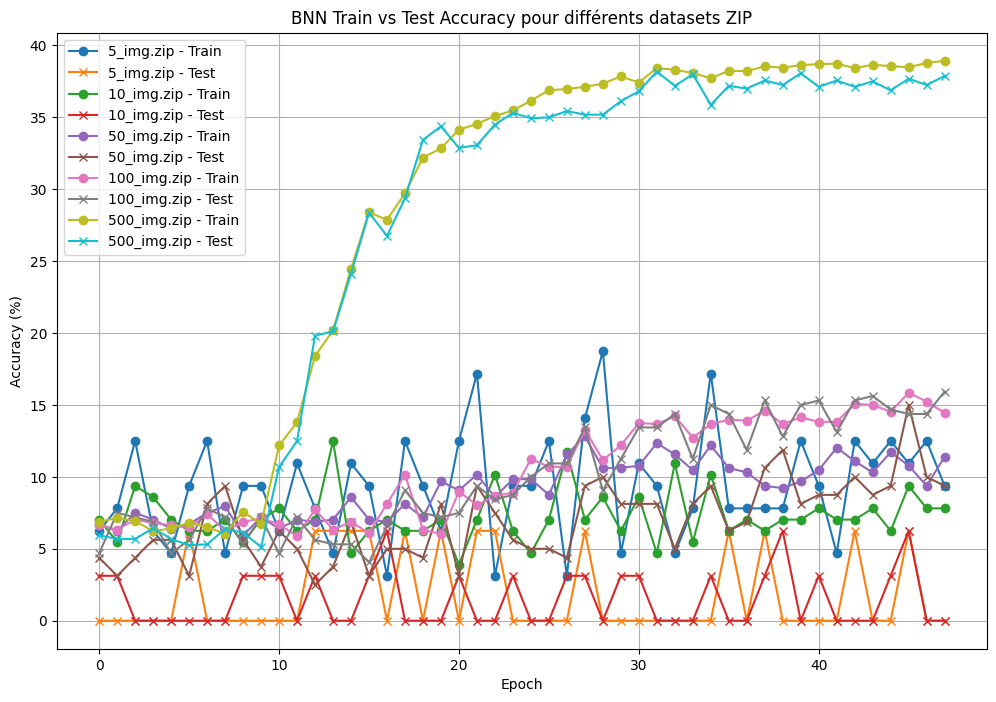

In [ ]:
# ----- Plot final -----
plt.figure(figsize=(12,8))

for label in all_train_accuracies:
    plt.plot(all_train_accuracies[label], marker='o', label=f"{label} - Train")
    plt.plot(all_test_accuracies[label], marker='x', label=f"{label} - Test")
    
plt.title("BNN Train vs Test Accuracy pour différents datasets ZIP")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.legend()
plt.savefig("comparaison_accuracy_bnn.svg", format="svg")

plt.show()